Pet Classification Algorithm
 Yash Patel (U11247717)

## Import Modules & Libraries & Define Basic Functions

In [1]:
# Import Necessary Modules
import glob
import matplotlib.pyplot as plt
import math
from skimage import io
import numpy as np
%matplotlib inline 

## `cats,dogs = read_cats_dogs()` function

In [2]:
#This function reads in all images in catsfolder/ and dogsfolder/. 
#Each 64 x 64 image is reshaped into a length-4096 row vector. 
#These row vectors are stacked on top of one another to get two data
#matrices, each with 4096 columns. The first matrix cats consists of all
#the cat images as row vectors and the second matrix dogs consists of all
#the dog images as row vectors.

def read_cats_dogs():
    
    # get image filenames
    cat_locs = glob.glob('catsfolder/*.jpg')
    dog_locs = glob.glob('dogsfolder/*.jpg')
    num_cats = len(cat_locs)
    num_dogs = len(dog_locs)
    
    # initialize empty arrays
    cats = np.zeros((num_cats,64*64))
    dogs = np.zeros((num_dogs,64*64))
              
    #reshape images into row vectors and stack into a matrix 
    for i in range(num_cats):
        img = cat_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        cats[i,:] = im

    for i in range(num_dogs):
        img = dog_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        dogs[i,:] = im

    return cats, dogs

## `show_image(X,i)` function

In [3]:
#This function takes in an n x 4096 data matrix X and an index i. It extracts
#the ith row of X and displays it as a grayscale 64 x 64 image.

def show_image(X, i):
    #select image
    image = X[i,:]
    #reshape make into a square
    image = image.reshape((64,64))
    #display the image
    plt.imshow(image,'gray')

## Splitting Data for k-folds cross validation

In [4]:
#Split the data into numfolds equal-sized segments
numfolds = 5 
#All but one fold used for training
trainfraction = (numfolds-1)/numfolds 
#Dimensions to try for PCA dimensionality reduction
kvalues = np.array([10, 25, 50, 100, 250, 500])
numkvalues = kvalues.size

## Initialize arrays to store error rate estimates

In [5]:
#Initialize arrays to store error rate estimates.
train_error_LDA = np.zeros((numfolds,numkvalues))
test_error_LDA = np.zeros((numfolds,numkvalues))
train_error_QDA = np.zeros((numfolds,numkvalues))
test_error_QDA = np.zeros((numfolds,numkvalues))

## Read in pet classificaton data 

In [6]:
#Read in pet classificaton data 
dataset0,dataset1 = read_cats_dogs()
#To speed up the script, load the cats and dogs dataset once, then
#comment out the line above while running the rest as you refine your code.
#Don't forget to uncomment the read_cats_dogs line if you restart.

## Get Size of Pet Data Set: `n0,do` && `n1,d1`

In [7]:
#Determine size of datasets.
n0,d0 = dataset0.shape
n1,d1 = dataset1.shape
n = n0 + n1
if (d0 == d1):
    d = d0
else:
    raise Exception("dataset0 and dataset1 do not have the same number of columns.")

## Create data matrix and label vector

In [8]:
#Create data matrix and label vector.
datamatrix = np.vstack((dataset0,dataset1))
labelvector = np.concatenate((np.zeros(n0),np.ones(n1)))
#Randomly permute dataset. As a result, the probability of error
#will change with each run of the whole script.
permutation = np.random.permutation(n) 

# Statistics Based Functions for Classification
## `error_rate_value = error_rate(yguess,ytrue)` function

In [9]:
def error_rate(yguess,ytrue):
    if (yguess.shape == ytrue.shape):
        numguesses = yguess.size
    else:
        raise Exception("yguess and ytrue are not the same shape.")
    error_rate_value = 1/numguesses*np.sum(yguess != ytrue)
    return error_rate_value

## `Xrun_reduced = dimensionality_reduction(Xrun,mu,V,D,k)` function

In [10]:
#This function takes in a data matrix Xrun, mean vector mu, 
#eigenvector matrix V, and eigenvalues D, and dimension k. 
#It selects the k eigenvectors corresponding to the k largest
#eigenvalues, centers the data by subtracting mu, and projects
#the centered data to k dimensions by multiplying by the matrix
#of k eigenvectors.
def dimensionality_reduction(Xrun,mu,V,D,k):
    max_vector_index = np.argsort(D)[::-1][:k]
    max_eigen_vectors = V[:,max_vector_index]
    
    '''
    print()
    print('max_eigen_vectors',max_eigen_vectors)
    print('Xrun_reduced = dimensionality_reduction(Xrun,mu,V,D,k) function')
    print('(Xrun - mu).shape',(Xrun - mu).shape)
    print('max_eigen_vectors.shape',max_eigen_vectors.shape)
    '''
    
    Xrun_reduced = (Xrun - mu) @ max_eigen_vectors
    return Xrun_reduced

## `n_label, mu_label, sigma_label = labeled_mean_cov(X,Y,desiredlabel)` function

In [11]:
#This function takes in a data matrix X, corresponding vector 
#of labels Y, and a desired label. It outputs the the number 
#of samples with desiredlabel as n_label as well as the sample
#mean vector mu_label and sample covariance matrix sigma_label
#for the data in X whose labels in Y are equal to desired label.
def labeled_mean_cov(X,Y,desiredlabel):
    X_reduced = X[Y==desiredlabel]
    n_label = len(X_reduced)
    mu_label = np.mean(X_reduced,axis=0)
    sigma_label = np.cov(X_reduced.T)  
    
    return n_label, mu_label, sigma_label

## `guesses = LDA(Xrun,mu0,mu1,sigmapooled)` function

In [12]:
#This function takes in a data matrix Xrun as well the mean vectors mu0, mu1 
#and the covariance matrices sigma0, sigma1 estimated from the training data
#and produces a vector guesses, corresponding to the ML rule for Gaussian vectors
#with different means and the same covariance matrix, which is referred to as 
#Linear Discriminant Analysis (LDA) in machine learning.
def LDA(Xrun,mu0,mu1,sigmapooled):
    #Apply Gaussian ML rule for same covariance matrices by using the log-likelihood ratio.
    inv_sigmapooled = np.linalg.pinv(sigmapooled)
    b = (2*inv_sigmapooled) @ (mu1 - mu0).T
    c = mu1@inv_sigmapooled@mu1.T - mu0@inv_sigmapooled@mu0.T
    
    guesses = np.zeros(Xrun.shape[0])


    for i in range(Xrun.shape[0]):
        if Xrun[i,:]@b >= c:
            guesses[i] = 1
        elif Xrun[i,:]@b < c:
            guesses[i] = 0
    return guesses

## `guesses = QDA(Xrun,mu0,mu1,sigma0,sigma1)` function

In [13]:
#This function takes in a data matrix Xrun as well the mean vectors mu0, mu1 
#and the covariance matrices sigma0, sigma1 estimated from the training data
#and produces a vector guesses, corresponding to the ML rule for Gaussian vectors
#with different means and different covariance matrices, which is referred to as 
#Quadratic Discriminant Analysis (QDA) in machine learning.
def QDA(Xrun,mu0,mu1,sigma0,sigma1):
    guesses = np.zeros(Xrun.shape[0])
    inv_sigma0 = np.linalg.pinv(sigma0)
    inv_sigma1 = np.linalg.pinv(sigma1)

    w,_ = np.linalg.eigh(sigma0)
    ld_sigma0 = np.sum(np.log(w))
    w,_ = np.linalg.eigh(sigma1)
    ld_sigma1 = np.sum(np.log(w))

    for i in range(Xrun.shape[0]):
        current = Xrun[i,:]
        lll_0 = -0.5 * ((current-mu0) @ inv_sigma0 @ np.transpose(current-mu0) + ld_sigma0)
        lll_1 = -0.5 * ((current-mu1) @ inv_sigma1 @ np.transpose(current-mu1) + ld_sigma1)
 
        guesses[i] = lll_0 <= lll_1
    return guesses

# void main() code
## Loop over folds, using the mth fold for testing, remainder for training

In [14]:
#Loop over folds, using the mth fold for testing, remainder for training.
for m in range(numfolds):
    print("Fold " + str(m+1) + " out of " + str(numfolds) + ".")
    permshift = np.roll(permutation,math.floor(n*m/numfolds))
    dataperm = datamatrix[permshift,:]
    labelperm = labelvector[permshift]
    #Split dataset into training and test data.
    Xtrain = dataperm[0:math.floor(n*trainfraction),:]
    Xtest = dataperm[math.floor(n*trainfraction):,:]
    Ytrain = labelperm[0:math.floor(n*trainfraction)]
    Ytest = labelperm[math.floor(n*trainfraction):]
    ntrain = Xtrain.shape[0]
    ntest = Xtest.shape[0]
    
    #Estimate mean vector and covariance matrix from Xtrain.
    mu = np.mean(Xtrain, axis=0)
    sigma = np.cov(Xtrain, rowvar=False)
    #Determine eigenvalues and eigenvectors.
    D, V = np.linalg.eigh(sigma) 
    #Loop over different sizes of dimension k for dimensionality reduction
    for j in range(numkvalues):
        k = kvalues[j] #Dimensionality reduction parameter.
        print("Trying dimension "+ str(k) + ".")
        #Reduce training and testing data to k dimensions.
        Xtrain_reduced = dimensionality_reduction(Xtrain,mu,V,D,k)
        Xtest_reduced = dimensionality_reduction(Xtest,mu,V,D,k)

        #Determine number of samples, mean vector, 
        #and covariance matrix for each label.
        n0train,mu0,sigma0 = labeled_mean_cov(Xtrain_reduced,Ytrain,0)
        n1train,mu1,sigma1 = labeled_mean_cov(Xtrain_reduced,Ytrain,1)        
        
        #Using the LDA algorithm (which is equivalent to modeling the data
        #as Gaussian with different mean vectors and the same covariance
        #matrix), produce guesses for the training and testing data.
        sigmapooled = 1/(n0train+n1train-2)*((n0train-1)*sigma0+(n1train-1)*sigma1)
        trainguesses_LDA = LDA(Xtrain_reduced,mu0,mu1,sigmapooled)
        testguesses_LDA = LDA(Xtest_reduced,mu0,mu1,sigmapooled)
        
        #Store resulting LDA error rates.
        train_error_LDA[m,j] = error_rate(trainguesses_LDA,Ytrain)
        test_error_LDA[m,j] = error_rate(testguesses_LDA,Ytest)
        
        #Using the QDA algorithm (which is equivalent to modeling the data
        #as Gaussian with different mean vectors and different covariance
        #matrices), produce guesses for the training and testing data.
        trainguesses_QDA = QDA(Xtrain_reduced,mu0,mu1,sigma0,sigma1)
        testguesses_QDA = QDA(Xtest_reduced,mu0,mu1,sigma0,sigma1)
        
        #Store resulting QDA error rates.
        train_error_QDA[m,j] = error_rate(trainguesses_QDA,Ytrain)
        test_error_QDA[m,j] = error_rate(testguesses_QDA,Ytest)

Fold 1 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.
Fold 2 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.
Fold 3 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.
Fold 4 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.
Fold 5 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.


## Determine average error rates over folds.

In [15]:
#Determine average error rates over folds.
avg_train_error_LDA = np.mean(train_error_LDA,axis=0)
avg_test_error_LDA = np.mean(test_error_LDA,axis=0)
avg_train_error_QDA = np.mean(train_error_QDA,axis=0)
avg_test_error_QDA = np.mean(test_error_QDA,axis=0)

## Plot average error rates

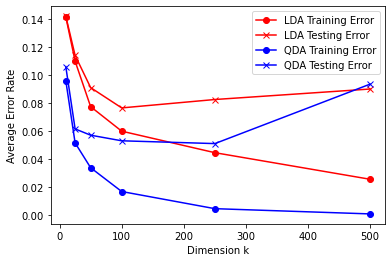

In [16]:
#Plot average error rates. 
fig = plt.figure()
plt.plot(kvalues,avg_train_error_LDA,marker="o",color="red")
plt.plot(kvalues,avg_test_error_LDA,marker="x",color="red")
plt.plot(kvalues,avg_train_error_QDA,marker="o",color="blue")
plt.plot(kvalues,avg_test_error_QDA,marker="x",color="blue")
plt.xlabel('Dimension k')
plt.ylabel('Average Error Rate')
plt.legend(['LDA Training Error','LDA Testing Error','QDA Training Error','QDA Testing Error'])
plt.show()